This is one of the 100 recipes of the IPython Cookbook, the definitive guide to high-performance scientific computing and data science in Python.  It has been lighrtly edited for expository purposes.

## 8.5. Using Support Vector Machines for classification tasks

Let's do some imports.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets as ds
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import GridSearchCV as gs
import sklearn.svm as svm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

We generate 2D points and assign a binary label according to a linear operation on the coordinates.

In [106]:
X = np.random.randn(200, 2)
y = X[:, 0] + X[:, 1] > 1

The label is True ("positive") if the sum of the two corrdinates is greater than 1; otherwise False.  This is an easy linear problem.

In [55]:
print(X.shape, X[0,0], X[0,1])
print(y[0])

(200, 2) 0.9932533795766834 -0.547775761988122
False


The values of the coordinates for the first item X[0,:] are shown, as well as the label, computed by the rule given above,

We now fit a linear **Support Vector Classifier** (SVC). This classifier tries to find a line (a line here, more generally a hyperplane) that separates the True labels from the False labels.  Otherwise put, we train the classifier.
The output of training is a decision function that tells us how close to the line we are (close to the boundary means a low-confidence decision).  Positive decision values mean True, Negative decision values mean False.

In [107]:
est = svm.LinearSVC()
est.fit(X, y);

For visualization purposes only (specifically, to use the contour plot below), 
we manipulate the data into a "mesh grid"
shape.  We're going to plot decisions for 250000 points in a 250x250 rectangle.
To do that we'll cast the decision results in the same 250x250 meshgrid shape.

In [5]:
# We generate a grid in the square [-3,3 ]^2.
xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))

# Flatten the meshgrid so the decision function can operate on the points in it
Z = est.decision_function(np.c_[xx.ravel(), yy.ravel()])
# Put the results back in meshgrid form.
Z = Z.reshape(xx.shape)

In [53]:
print(xx.shape,Z.shape)
print('Four sample points in the grid, first row the x-ordinates, second row the y')

print(f'{xx[0,0]: 2.3f}, {xx[1,0]: 2.3f}, {xx[0,1]: 2.3f}, {xx[1,1]: 2.3f}')
print(f'{yy[0,0]: 2.3f}, {yy[1,0]: 2.3f}, {yy[0,1]: 2.3f}, {yy[1,1]: 2.3f}')
print()
print('Now the value of the decision function for those points.  It will be a high positive number for high-confidence positive decisions.')
print('It will have a low absolute value (near 0) for low-confidence decisions.')
print('It will change each time you run this notebook, because a new set of random points is chosen on each run.')
print()
print(f'{Z[0,0]: 2.3f}, {Z[0,1]: 2.3f}, {Z[1,0]: 2.3f}, {Z[1,1]: 2.3f}')
print()
print('The real shape of the data in table form is 250000 2 D points, a 250000x2 array')
print(np.c_[xx.ravel(),yy.ravel()].shape)

(500, 500) (500, 500)
Four sample points in the grid, first row the x-ordinates, second row the y
-3.000, -3.000, -2.988, -2.988
-3.000, -2.988, -3.000, -2.988

Now the value of the decision function for those points.  It will be a high positive number for high-confidence positive decisions.
It will have a low absolute value (near 0) for low-confidence decisions.
It will change each time you run this notebook, because a new set of random points is chosen on each run.

-15.554, -15.528, -15.527, -15.501

The real shape of the data in table form is 250000 2 D points, a 250000x2 array
(250000, 2)


We define a function that displays the boundaries and decision function of a trained classifier.  The `scatter` function displays our points on the 2D grid we defined.  We show the regions of the grid where the decision surface `Z` has the highest values in dark blue with `imshow`, and we show the place where `Z` is 0 with the `contour` function, instructing it to draw a black line along the pointss where `z=0`.  The `scatter` function assigns a color to points as well.  Those for which the class value (`y`) is 1 are dark; those with class value 0 are light (open circles).  We draw dashed axis lies with the two `axhline` and `axvline` commands.

In [108]:
# This function takes a SVM estimator as input.
def plot_decision_function(est, y, confidence_plot = False, figside=6):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                         np.linspace(-3, 3, 500))
    # We evaluate the decision function on the grid.
    Z = est.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cmap = plt.cm.Blues
    # We display the decision function on the grid.
    plt.figure(figsize=(figside,figside));
    toshow = np.abs(Z) if confidence_plot else Z
    plt.imshow(toshow,
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                aspect='auto', origin='lower', cmap=cmap);
    # We display the boundary where Z = 0
    plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                colors='k');
    # All point colors c fall in the interval .5<=c<=1.0 on the blue colormap. We color the true points darker blue.
    plt.scatter(X[:, 0], X[:, 1], s=30, c=.5+.5*y, lw=1, 
                cmap=cmap, vmin=0, vmax=1);
    plt.axhline(0, color='k', ls='--');
    plt.axvline(0, color='k', ls='--');
    plt.xticks(());
    plt.yticks(());
    plt.axis([-3, 3, -3, 3]);

5) Let's take a look at the classification results with the linear SVC.

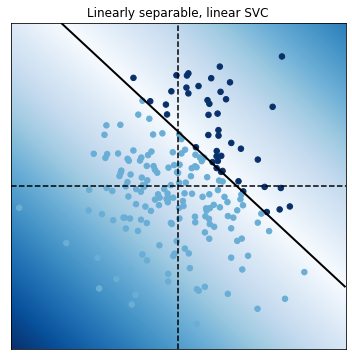

In [109]:
plot_decision_function(est, y, confidence_plot = True);
plt.title("Linearly separable, linear SVC");

The linear SVC tried to separate the points with a line and it did a pretty good job.

## A margin

Next we'll take our super-easy classification problem and make it even easier by inserting more distance between the positve and negative instances.  Let's modify our point locations
so that there is a "no man's land" between the positive and negative points.  This demonstrates that the idea of an SVM is not just drawing any linear separator but drawing the one that "maximizes" the "margin" (distance) between the separating plane and the nearest examples.

In the two cells we create a new dataset in which the Xvalues of just the positive points have been increased by 1.

In [68]:
F = np.zeros(len(y),dtype=bool)
print(F[:4])

[False False False False]


How `np.where` works:

In [87]:
a = np.arange(10)
print(a)
np.where(a < 5, a, 10*a)

[0 1 2 3 4 5 6 7 8 9]


array([ 0,  1,  2,  3,  4, 50, 60, 70, 80, 90])

In [110]:
Y = np.c_[y,F]
NX = np.where(Y,X+1,X)

Line 1: We made new `Y` to use as a condition for creating new data.

Second column of Y is always `False`, first is the same as `y`.

Line 2:  Make the new X-data `NX`; leave the Y-coordinate (second column) as before.  add 1 to the corrd of the X's that were `True`.
dave the other X-values as before.

In [89]:
Y[:5]

array([[False, False],
       [False, False],
       [False, False],
       [False, False],
       [ True, False]])

In [91]:
print(X[:5])
print()
print(NX[:5])

[[ 0.99325338 -0.54777576]
 [ 0.19110131 -0.07447071]
 [ 1.16429395 -1.61773355]
 [-0.18604191 -0.19235496]
 [ 0.45937739  1.46120828]]

[[ 0.99325338 -0.54777576]
 [ 0.19110131 -0.07447071]
 [ 1.16429395 -1.61773355]
 [-0.18604191 -0.19235496]
 [ 1.45937739  1.46120828]]


The positive negative rule will be the same, the label is True ("positive") if the sum of the two ORIGINAL coordinates is greater than 1; otherwise False.  So we use the same y.

We now fit a linear **Support Vector Classifier** (SVC) to the modified data.

In [111]:
est = svm.LinearSVC(random_state=44)
est.fit(NX, y);

We now define a slightly modified function that displays the boundaries and decision function of a trained classifier, as before, and adds dashed lines to show the margin between the
separating line and the nearest data points.

In [112]:
# This function takes a SVM estimator as input.
def new_plot_decision_function(est, y, confidence_plot = False, figside=6):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                         np.linspace(-3, 3, 500))
    # We evaluate the decision function on the grid.
    Z = est.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cmap = plt.cm.Blues
    # We display the decision function on the grid.
    plt.figure(figsize=(figside,figside));
    toshow = np.abs(Z) if confidence_plot else Z
    plt.imshow(toshow,
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                aspect='auto', origin='lower', cmap=cmap);            
    # We display the boundary where Z = 0
    plt.contour(xx, yy, Z, levels=[-.5,0,.5], linewidths=2,
                colors='k',negative_linestyles=['dashed'],linestyles=['dashed','solid'])
    # All point colors c fall in the interval .5<=c<=1.0 on the blue colormap. We color the true points darker blue.
    plt.scatter(NX[:, 0], NX[:, 1], s=30, c=0+.5*y, lw=1, 
                cmap=cmap, vmin=0, vmax=1);
    plt.axhline(0, color='k', ls=':');
    plt.axvline(0, color='k', ls=':');
    plt.xticks(());
    plt.yticks(());
    plt.axis([-3, 3, -3, 3]);

5) Let's take a look at the classification results with the linear SVC.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'negative_linestyles'


Text(0.5, 1.0, 'Separable with margin, linear SVC')

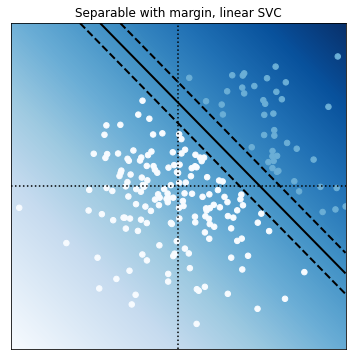

In [113]:
new_plot_decision_function(est, y)
plt.title("Separable with margin, linear SVC")

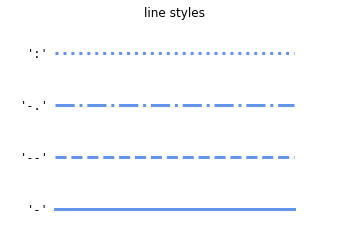

In [75]:
"""
====================
Line-style reference
====================

Reference for line-styles included with Matplotlib.
"""
import numpy as np
import matplotlib.pyplot as plt


color = 'cornflowerblue'
points = np.ones(5)  # Draw 5 points for each line
text_style = dict(horizontalalignment='right', verticalalignment='center',
                  fontsize=12, fontdict={'family': 'monospace'})


def format_axes(ax):
    ax.margins(0.2)
    ax.set_axis_off()


def nice_repr(text):
    return repr(text).lstrip('u')


# Plot all line styles.
fig, ax = plt.subplots()

linestyles = ['-', '--', '-.', ':']
for y, linestyle in enumerate(linestyles):
    ax.text(-0.1, y, nice_repr(linestyle), **text_style)
    ax.plot(y * points, linestyle=linestyle, color=color, linewidth=3)
    format_axes(ax)
    ax.set_title('line styles')

plt.show()

## A non separable example

We now modify the labels with a *XOR* function. A point's label is 1 if the coordinates have different signs. This classification is not linearly separable. Therefore, a linear SVC fails completely.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn


fitting done!



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Score: 0.6


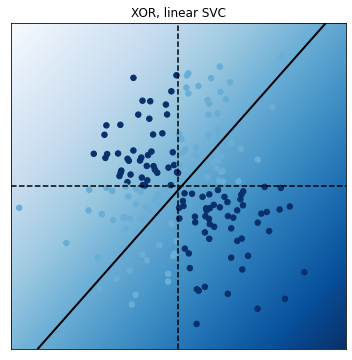

In [114]:
y2 = (X[:, 0] > 0) ^ (X[:, 1] > 0)
# We train the classifier.
est = gs(svm.LinearSVC(random_state=42), 
          {'C': np.logspace(-3., 3., 10)});
est.fit(X, y2);
print()
print('fitting done!')
print()
# We'll do cross validation on the training data, and take mean()
# cv_res is a dict
cv_res = cv(est, X, y2)
print(("Score: {0:.1f}".format(
      cv_res['test_score'].mean())))
# Plot the decision function.
plot_decision_function(est,y2);
plt.title("XOR, linear SVC");

Line 11-13: We do cross validation on the training data and take the mean().

`cv_res` is a `dict` containing values for various efficiency & performance metrics:

In [115]:
print(cv_res.keys())
cv_res['test_score']

dict_keys(['fit_time', 'score_time', 'test_score'])


array([0.55, 0.55, 0.6 , 0.5 , 0.6 ])

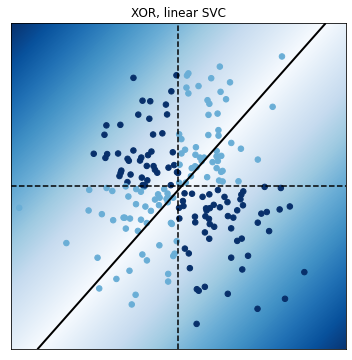

In [116]:
plot_decision_function(est,y2,confidence_plot=True);
plt.title("XOR, linear SVC");

Fortunately, it is possible to use non-linear SVCs by using non-linear **kernels**. Kernels specify a non-linear transformation of the points into a higher-dimensional space. Transformed points in this space are assumed to be more linearly separable, although they are not necessarily in the original space. By default, the `SVC` classifier in scikit-learn uses the **Radial Basis Function** (RBF) kernel.

/Users/gawron/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/gawron/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/gawron/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/gawron/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version

Score: 0.945


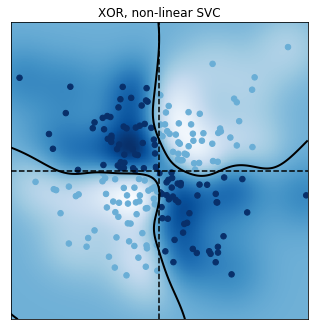

In [ ]:
y = (X[:, 0] > 0) ^ (X[:, 1] > 0)
# We're going to do a grid search (gs)
# trying out 100 different value-settings
# for the parameter pair C and gamma to
# find the pair of values with best performance.
est = gs(svm.SVC(), 
          {'C': np.logspace(-3., 3., 10),
           'gamma': np.logspace(-3., 3., 10)});
est.fit(X, y);
cv_res = cv(est, X, y)
print(("Score: {0:.3f}".format(
      cv_res['test_score'].mean())))
plot_decision_function(est.best_estimator_);
plt.title("XOR, non-linear SVC");

This time, the non-linear SVC does a pretty good job at classifying these non-linearly separable points.

> You'll find all the explanations, figures, references, and much more in the book (to be released later this summer).

> [IPython Cookbook](http://ipython-books.github.io/), by [Cyrille Rossant](http://cyrille.rossant.net), Packt Publishing, 2014 (500 pages).